## 1. Load Modules

In [1]:
os.chdir('/Users/liyangling/workspace/Projects/Python/SparkDBSCAN')

from src.utils import DataLoader, Evaluation, timeit
from src.settings import UNKNOWN, NOISE
# from serial import MatrixDBSCAN, NaiveDBSCAN
# from src.parallel import parallel_dbscan, load_data, load_data_label

# from src.parallel.dbscan_rtree import rtree_partition
# from src.parallel import spatial_partition, local_dbscan, merge
# from src.parallel import load_data, load_data_label

In [2]:
import numpy as np
import pandas as pd
from rtree import index
from collections import deque
from queue import PriorityQueue
import math

## 1.2 Setial DBSCAN Module

In [3]:
class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a], 2).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)

    def _get_neighbours(self, p: int) -> list:
        """
        return neighbours index of given point p in source data matrix
        :param: p: int; index of given point in data matrix
        """
        pass

    def _clustering(self, p, cluster_id):
        """
        tag given point p and all of its neighbours and sub-neighbours with the same cluster id
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: cluster_id: int; current id of cluster
        """
        pass

    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)


class NaiveDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(NaiveDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_neighbours(self, p: int) -> list:

        ngbs = []
        for idx in range(len(self.m)):
            if self._get_dist(p, idx) < self.eps:
                ngbs.append(idx)
        return ngbs

    def _clustering(self, p, cluster_id) -> bool:

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0]

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True

## 2. Parallel Implementation

In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### 2.1 General DBSCAN

In [5]:
def load_data_label(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def load_data(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def _bounds_coordinates(bin_bounds):

    lower_cdnts = [[low] for low in  bin_bounds[0][:-1]]
    upper_cdnts = [[high] for high in bin_bounds[0][1:]]
    
    # super stupid implementation, optimization needed
    for bound in bin_bounds[1:]:
        lower_tmp = []
        upper_tmp = []
        
        for bc in bound[:-1]:
            lower_tmp.extend([lc + [bc] for lc in lower_cdnts])
        lower_cdnts = lower_tmp
        
        for bc in bound[1:]:
            upper_tmp.extend([uc + [bc] for uc in upper_cdnts])
        upper_cdnts = upper_tmp
        
    return np.array(lower_cdnts), np.array(upper_cdnts)

@timeit
def spatial_partition(dataset, n_partitions, eps):
    """
    n_partitions: tuple with shape correspoding to dataset dimension
    """
    tp_par = n_partitions
    num_par = np.prod(n_partitions)
    # cut bins
    bounds = np.concatenate(([np.min(dataset, axis=0)], [np.max(dataset, axis=0)]), axis=0)     # 2 * D
    bounds_dim = bounds.T   # D * 2, 
    
    bin_bounds = []
    for i in range(len(tp_par)):
        dim_bins = np.linspace(*bounds_dim[i], tp_par[i]+1, endpoint=True)
        bin_bounds.append(dim_bins)
    
    lower_bounds, upper_bounds = _bounds_coordinates(bin_bounds)
    lower_bounds -= eps
    upper_bounds += eps

    # scatter points into bins with eps
    indexed_data = []
    for id_pts in range(len(dataset)):     # index of point in dataset
        for id_ptt in range(num_par):
            if not (dataset[id_pts] > lower_bounds[id_ptt]).all():
                continue
            if not (dataset[id_pts] < upper_bounds[id_ptt]).all():
                continue
            indexed_data.append([id_ptt, id_pts])
            
    res = sc.parallelize(indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res

def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):

    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    else:
        dbscan_obj = NaiveDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()
    
    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))

@timeit
def merge(local_tags, dataset):
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0
    for local in local_tags:
        np_local = np.array(local[-1])
        np_local[:, -1] += last_max_label

        last_max_label = np.max(np_local[:, -1])
        
        # check and merge overlapped points
        tagged_indices = np.nonzero(is_tagged)[0]
        for tmp_i in range(len(np_local)):
            # should do tag check
            (p_id, is_core), label = np_local[tmp_i]
            if p_id in tagged_indices and is_core==1:
                np_local[-1][np_local[-1]==label] = global_tags[p_id]
        
        # update global tags
        for (p_id, is_core), label in np_local:
            if is_tagged[p_id]==1:
                continue
            global_tags[p_id] = label
            is_tagged[p_id] = 1
    return global_tags

### 2.2 RTree DBSCAN

In [6]:
def _get_cost(bounds, nPoints, fanout=2):
    h = math.log((nPoints + 1) / fanout, fanout) + 1
    DA = h + math.sqrt(nPoints) * 2 / (math.sqrt(fanout) -
                                       1) + nPoints / (fanout - 1) + 1
    return DA * nPoints


def cost_base_partition(rtree, maxCost, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()
    queue.append(mbr)
    while len(queue):
        br = queue.popleft()
        nPoints = rtree.count(br)
        if get_cost(br, nPoints) > maxCost:
            (subbr1, subbr2) = _cost_base_split(rtree, br, eps)
            queue.append(subbr1)
            queue.append(subbr2)
        else:
            partition_list.append(br)
    return partition_list


def _cost_base_split(rtree, bounds, eps):
    (xmin, ymin, xmax, ymax) = bounds
    #vertical split
    ymin_diff = float('inf')
    ysplit = ymin + (ymax - ymin) / 2
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))
    while (ysplit + eps * 2 <= ymax):
        lowerbr = (xmin, ymin, xmax, ysplit)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xmin, ysplit, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < ymin_diff:
            ymin_diff = costdiff
            ybest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                ysplit = ymin + (ysplit - ymin) / 2
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    #horizontal split
    xmin_diff = float('inf')
    xsplit = xmin + (xmax - xmin) / 2
    xbest_split = ((xmin, ymin, xsplit, ysplit), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        lowerbr = (xmin, ymin, xsplit, ymax)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xsplit, ymin, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < xmin_diff:
            xmin_diff = costdiff
            xbest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    #compare ysplit and xsplit
    if xmin_diff < ymin_diff:
        return xbest_split
    else:
        return ybest_split


def reduced_boundary_partition(rtree, maxPoints, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()
    queue.append(mbr)
    while len(queue):
        br = queue.popleft()
        nPoints = rtree.count(br)
        if nPoints > maxPoints:
            (br1, br2) = _reduced_boundary_split(rtree, br, eps)
            queue.append(br1)
            queue.append(br2)
        else:
            partition_list.append(br)
    return partition_list


def _reduced_boundary_split(rtree, br, eps):

    (xmin, ymin, xmax, ymax) = br

    #vertical splitline candidates
    ymin_score = float('inf')
    ysplit = ymin + (ymax - ymin) / 2
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))
    while (ysplit + eps * 2 <= ymax):
        br1 = (xmin, ymin, xmax, ysplit)
        br2 = (xmin, ysplit, xmax, ymax)
        point_diff = abs(rtree.count(br1) - rtree.count(br2))
        score = point_diff * rtree.count(
            (xmin, ysplit - eps, xmax, ysplit + eps))
        if score < ymin_score:
            ymin_score = score
            ybest_split = (br1, br2)
            if rtree.count(br1) > rtree.count(br2):
                ysplit = ymin + (ysplit - ymin) / 2
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    #horizontal splitline candidates
    xsplit = xmin + eps * 2
    xmin_score = float('inf')
    xbest_split = ((xmin, ymin, xsplit, ymax), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        br1 = (xmin, ymin, xsplit, ymax)
        br2 = (xsplit, ymin, xmax, ymax)
        point_diff = abs(rtree.count(br1) - rtree.count(br2))
        score = point_diff * rtree.count((xmin - eps, ymin, xmin + eps, ymax))
        if score < xmin_score:
            xmin_score = score
            xbest_split = (br1, br2)
            if rtree.count(br1) > rtree.count(br2):
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    if xmin_score < ymin_score:
        return xbest_split
    else:
        return ybest_split


#construct rtree index
def construct_rtree_index(dataset):
    p = index.Property()
    rtree_idx = index.Index(properties=p)
    count = 0
    for coordinate in dataset:
        rtree_idx.insert(count, (*coordinate, *coordinate))
        count += 1
    return rtree_idx


def cbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    cost = _get_cost(mbr, rtree.count(mbr))
    queue.put((-cost, mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _cost_base_split(rtree, br, eps)
        for subbr in subbrs:
            cost = _get_cost(subbr, rtree.count(subbr))
            queue.put((-cost, subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list


def rbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    queue.put((-rtree.count(mbr), mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _reduced_boundary_split(rtree, br, eps)
        for subbr in subbrs:

            queue.put((-rtree.count(subbr), subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list


@timeit
def rtree_partition(dataset, n_patitions, eps, mtd='cbs'):
    """
    params:parameters needed for different spliting method; for cost-base method params=('cbs', max_cost);
    for reduced-boundary method params = ('rbs', max_points)
    """
    idx = construct_rtree_index(dataset)
    # #split test
    if mtd == 'cbs':
        partitioned = cbs_fixnum(idx, eps, n_patitions)
    else:
        partitioned = rbs_fixnum(idx, eps, n_patitions)

    indexed_data = []
    id_ptt = 0
    for boundary in partitioned:
        (left, bot, right, top) = boundary
        for id_pts in idx.intersection(
            (left - eps, bot - eps, right + eps, top + eps)):
            indexed_data.append([id_ptt, id_pts])
        id_ptt += 1

    res = sc.parallelize(
        indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res


### 2.3 Entry Functions

In [7]:
def partition(dataset, eps, partition_tuple, rtree=False, rtree_mtd='cbs'):
    if rtree:
        partition_tuple = np.prod(partition_tuple)
        partitioned_rdd = rtree_partition(dataset,
                                          partition_tuple,
                                          eps,
                                          mtd=rtree_mtd)
    else:
        partitioned_rdd = spatial_partition(dataset, partition_tuple, eps)
    return partitioned_rdd


# parallel entry function
@timeit
def parallel_dbscan(dataset,
                    eps,
                    min_pts,
                    partition_tuple,
                    method='matrix',
                    metric='euclidian',
                    rtree=False,
                    rtree_mtd='cbs',
                    verbose=False):

    #     b_dataset = sc.broadcast(dataset)
    #     b_eps = sc.broadcast(eps)
    #     b_min_pts = sc.broadcast(min_pts)
    partitioned_rdd = partition(dataset,
                                eps,
                                partition_tuple,
                                rtree=rtree,
                                rtree_mtd=rtree_mtd)
    local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(
        x, method=method, metric=metric)).collect()
    result_tags = merge(local_tags, dataset)
    
    if verbose:
        p = partitioned_rdd.collect()
        print('Partition info:')
        for i in range(len(p)):
            print('partition ', p[i][0],
                  ', num of points: ', len(p[i][1]),
                  ', num of clusters: ', len(np.unique(np.array(local_tags[i][-1])[:, 1])))
        print('Number of Clusters:')

    return result_tags


## 3. 

## 4. Plot Module

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib notebook

def plot_result(dataset, result_tags, file_name=None, style='ticks'):
    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags
    
    # sns preparation
#     sns.set_context("notebook", font_scale=1)
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    
    sns.scatterplot('x', 'y',data=df, ax=axes[0], palette='Blues_d')
    sns.scatterplot('x', 'y', data=df, hue='label', ax=axes[1])
    
    plt.title(f'DBSCAN Result of {file_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    
#     plt.legend(loc='upper right')
    plt.gca().get_legend().set_visible(False)

    plt.tight_layout()
    plt.show()

## 5. Test Playground

### 5.1 R15 dataset

predict time cost: 2178.1158447265625ms
eps: 0.7 min points: 12 silhouette coefficient: 0.7544791263199666


<IPython.core.display.Javascript object>


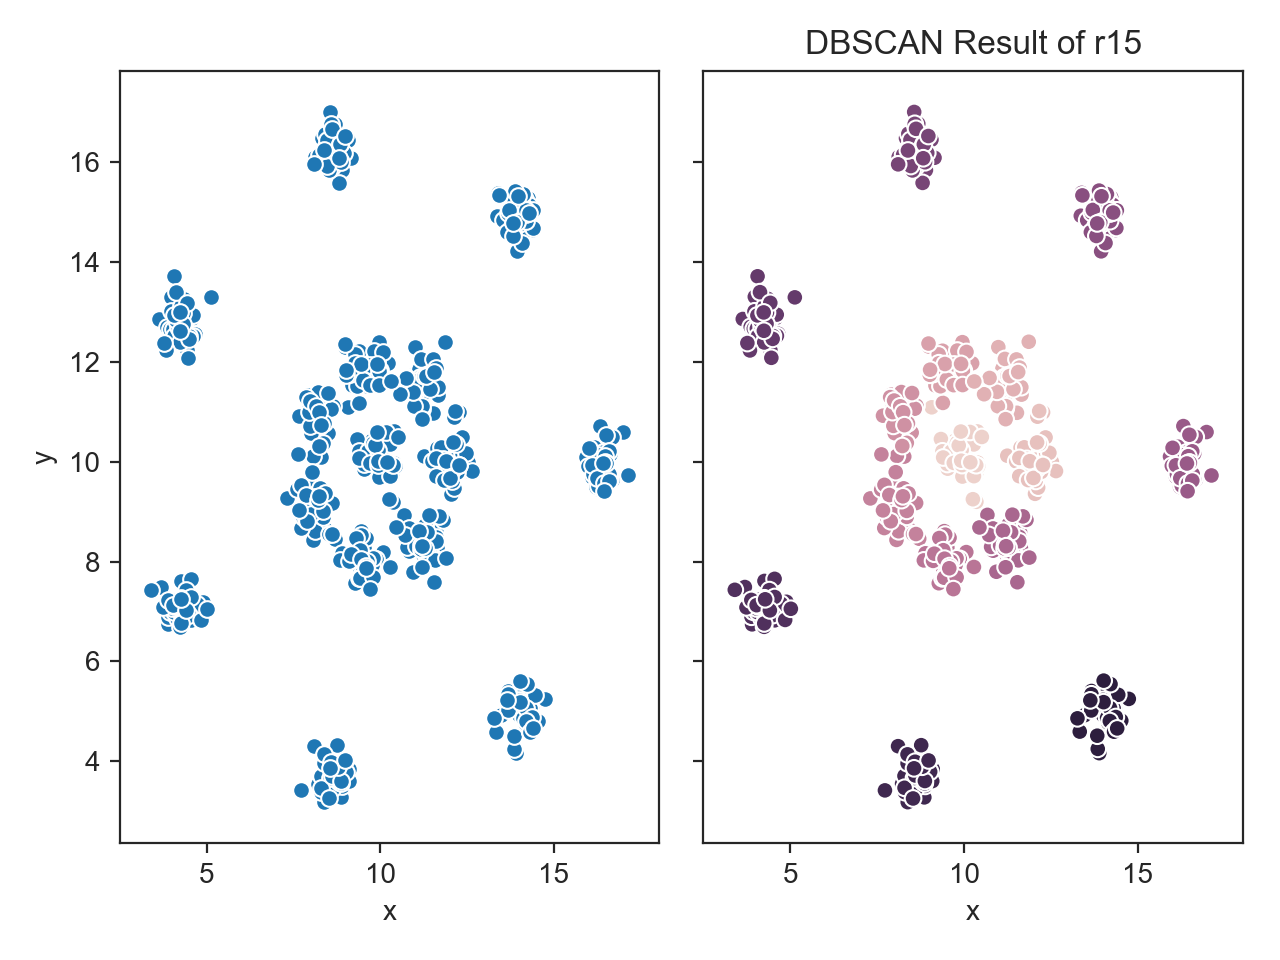

In [54]:
test_file = '../../data/shape-sets/r15_600.txt'
dataset = np.array(load_data_label(test_file))
n_partitions = (4, 2)
eps = 0.7
min_pts = 12

mdbscan = MatrixDBSCAN(dataset, eps, min_pts)
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)
del mdbscan
plot_result(dataset, result_tags, 'r15')

### 5.2 parallel

### 5.2.1 r15_600

In [9]:
test_file = '../../data/shape-sets/r15_600.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), (2, 4), (4, 4)]
# n_partition_set = [(2, 4), (4, 4), (4, 8)]
eps = 0.7
min_pts = 12
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

In [10]:
# # serial naive
# print('\nSERIAL:')
# mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
# result_tags = mdbscan.predict()

# print('\nSERIAL:')
# mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
# result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for tuple_par in n_partition_set:
    print(f'\nPartitions: {np.prod(tuple_par)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian')
    
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')
    
    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')
# dbscan_obj = MatrixDBSCAN(dataset, eps, min_pts)
# dbscan_obj.tags = result_tags
# dbscan_obj.eps = eps
# dbscan_obj.min_pts = min_pts
# Evaluation.silhouette_coefficient(dbscan_obj)



Partitions: 4

NAIVE:
spatial_partition time cost: 44.641971588134766ms
merge time cost: 4.747867584228516ms
parallel_dbscan time cost: 1488.3041381835938ms

MATRIX:
spatial_partition time cost: 23.340940475463867ms
merge time cost: 5.663156509399414ms
parallel_dbscan time cost: 489.2261028289795ms

FAST-MATRIX:
spatial_partition time cost: 29.5259952545166ms
merge time cost: 5.331277847290039ms
parallel_dbscan time cost: 434.3869686126709ms

Rtree-cbs:
rtree_partition time cost: 32.26494789123535ms
merge time cost: 8.527040481567383ms
parallel_dbscan time cost: 553.9309978485107ms

Rtree-rbs:
rtree_partition time cost: 56.68210983276367ms
merge time cost: 4.098176956176758ms
parallel_dbscan time cost: 587.9256725311279ms

Partitions: 8

NAIVE:
spatial_partition time cost: 29.345035552978516ms
merge time cost: 5.138158798217773ms
parallel_dbscan time cost: 852.4720668792725ms

MATRIX:
spatial_partition time cost: 29.991865158081055ms
merge time cost: 5.064964294433594ms
parallel_dbsca

### 5.2.2 jain_373

In [95]:
test_file = '../../data/shape-sets/jain_373.txt'
dataset = np.array(load_data_label(test_file))
eps = 2
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

print('\nFAST-MATRIX:')
result_tags = parallel_dbscan(dataset, eps, min_pts, (2,2), method='matrix', metric='fast-euclidian', verbose=True)

print('\nRtree-rbs:')
result_tags = parallel_dbscan(dataset, eps, min_pts, (2,2), method='matrix', metric='fast-euclidian',
                             rtree=True, rtree_mtd='rbs', verbose=True)
print('\nRtree-cbs:')
result_tags = parallel_dbscan(dataset, eps, min_pts, (2,2), method='matrix', metric='fast-euclidian',
                             rtree=True, rtree_mtd='cbs', verbose=True)


FAST-MATRIX:
spatial_partition time cost: 24.726152420043945ms
merge time cost: 2.7587413787841797ms
Partition info:
partition  0 , num of points:  114 , num of clusters:  5
partition  1 , num of points:  225 , num of clusters:  8
partition  2 , num of points:  110 , num of clusters:  2
partition  3 , num of points:  60 , num of clusters:  2
Number of Clusters:
parallel_dbscan time cost: 508.33702087402344ms

Rtree-rbs:
rtree_partition time cost: 34.6682071685791ms
merge time cost: 3.2210350036621094ms
Partition info:
partition  0 , num of points:  155 , num of clusters:  4
partition  1 , num of points:  138 , num of clusters:  4
partition  2 , num of points:  120 , num of clusters:  2
partition  3 , num of points:  105 , num of clusters:  4
Number of Clusters:
parallel_dbscan time cost: 286.14234924316406ms

Rtree-cbs:
rtree_partition time cost: 35.60519218444824ms
merge time cost: 2.9239654541015625ms
Partition info:
partition  0 , num of points:  158 , num of clusters:  3
partition

In [11]:
test_file = '../../data/shape-sets/jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 2
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))


for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')

    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')


SERIAL:
predict time cost: 1446.9718933105469ms

SERIAL:
predict time cost: 760.4210376739502ms
Number of clusters: 11

Partitions: 4

NAIVE:
spatial_partition time cost: 20.48516273498535ms
merge time cost: 2.6197433471679688ms
parallel_dbscan time cost: 1252.882957458496ms

MATRIX:
spatial_partition time cost: 19.721031188964844ms
merge time cost: 2.457857131958008ms
parallel_dbscan time cost: 417.93203353881836ms

FAST-MATRIX:
spatial_partition time cost: 16.912221908569336ms
merge time cost: 3.5288333892822266ms
parallel_dbscan time cost: 380.10215759277344ms

Rtree-rbs:
rtree_partition time cost: 29.281139373779297ms
merge time cost: 2.959012985229492ms
parallel_dbscan time cost: 278.1951427459717ms

Rtree-cbs:
rtree_partition time cost: 28.400182723999023ms
merge time cost: 3.5049915313720703ms
parallel_dbscan time cost: 252.5482177734375ms

Partitions: 8

NAIVE:
spatial_partition time cost: 30.007123947143555ms
merge time cost: 3.681182861328125ms
parallel_dbscan time cost: 788

predict time cost: 857.8329086303711ms
Number of clusters: 8


<IPython.core.display.Javascript object>


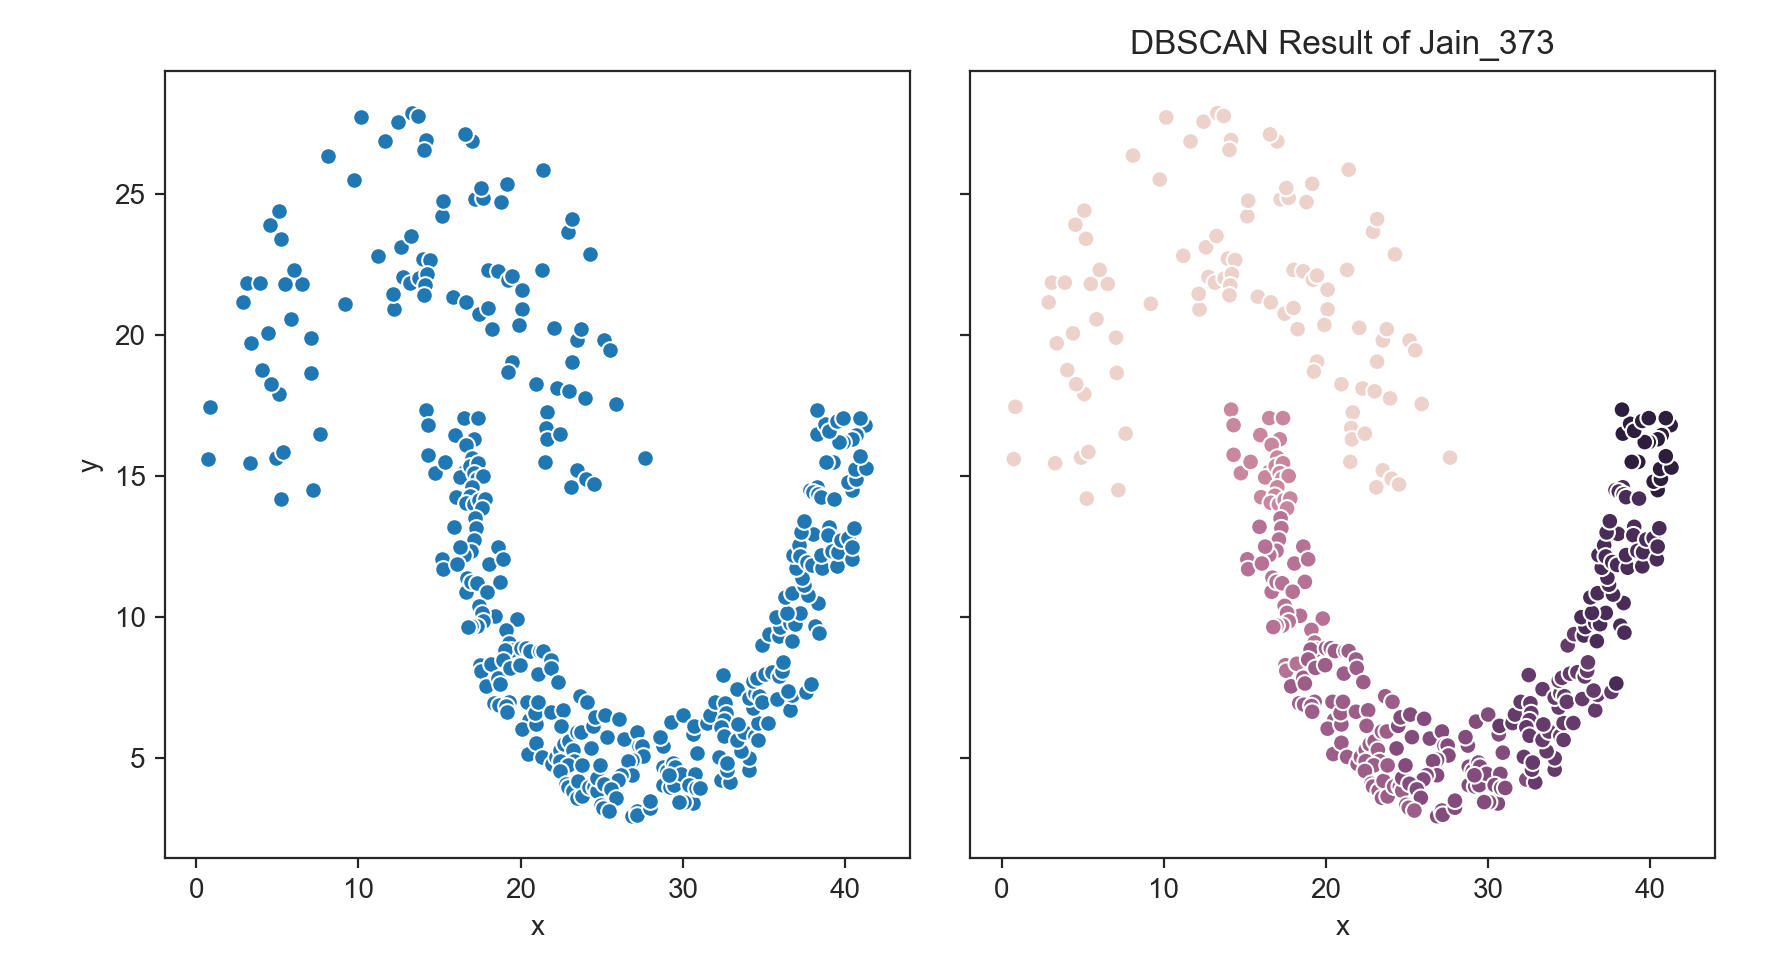

eps: 3 min points: 18 silhouette coefficient: 0.30428701469580155


0.30428701469580155

In [110]:
test_file = '../../data/shape-sets/jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 3
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))
plot_result(dataset, result_tags, 'Jain_373')
Evaluation.silhouette_coefficient(mdbscan)


### 5.2.4 pathbased_300

In [111]:
test_file = '../../data/shape-sets/pathbased_300.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 1.8
min_pts = 6
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')



SERIAL:
predict time cost: 1060.54ms

SERIAL:
predict time cost: 514.133ms

Partitions: 4

NAIVE:
partition time cost: 16.084ms
merge time cost: 2.463ms
parallel_dbscan time cost: 443.846ms

MATRIX:
partition time cost: 15.674ms
merge time cost: 2.912ms
parallel_dbscan time cost: 167.96ms

FAST-MATRIX:
partition time cost: 16.052ms
merge time cost: 2.462ms
parallel_dbscan time cost: 159.675ms

Partitions: 8

NAIVE:
partition time cost: 20.021ms
merge time cost: 2.882ms
parallel_dbscan time cost: 330.946ms

MATRIX:
partition time cost: 18.738ms
merge time cost: 3.238ms
parallel_dbscan time cost: 160.748ms

FAST-MATRIX:
partition time cost: 20.749ms
merge time cost: 3.026ms
parallel_dbscan time cost: 177.364ms

Partitions: 16

NAIVE:
partition time cost: 30.615ms
merge time cost: 5.307ms
parallel_dbscan time cost: 299.324ms

MATRIX:
partition time cost: 30.119ms
merge time cost: 5.293ms
parallel_dbscan time cost: 173.822ms

FAST-MATRIX:
partition time cost: 30.179ms
merge time cost: 5.3

predict time cost: 557.495ms


<IPython.core.display.Javascript object>


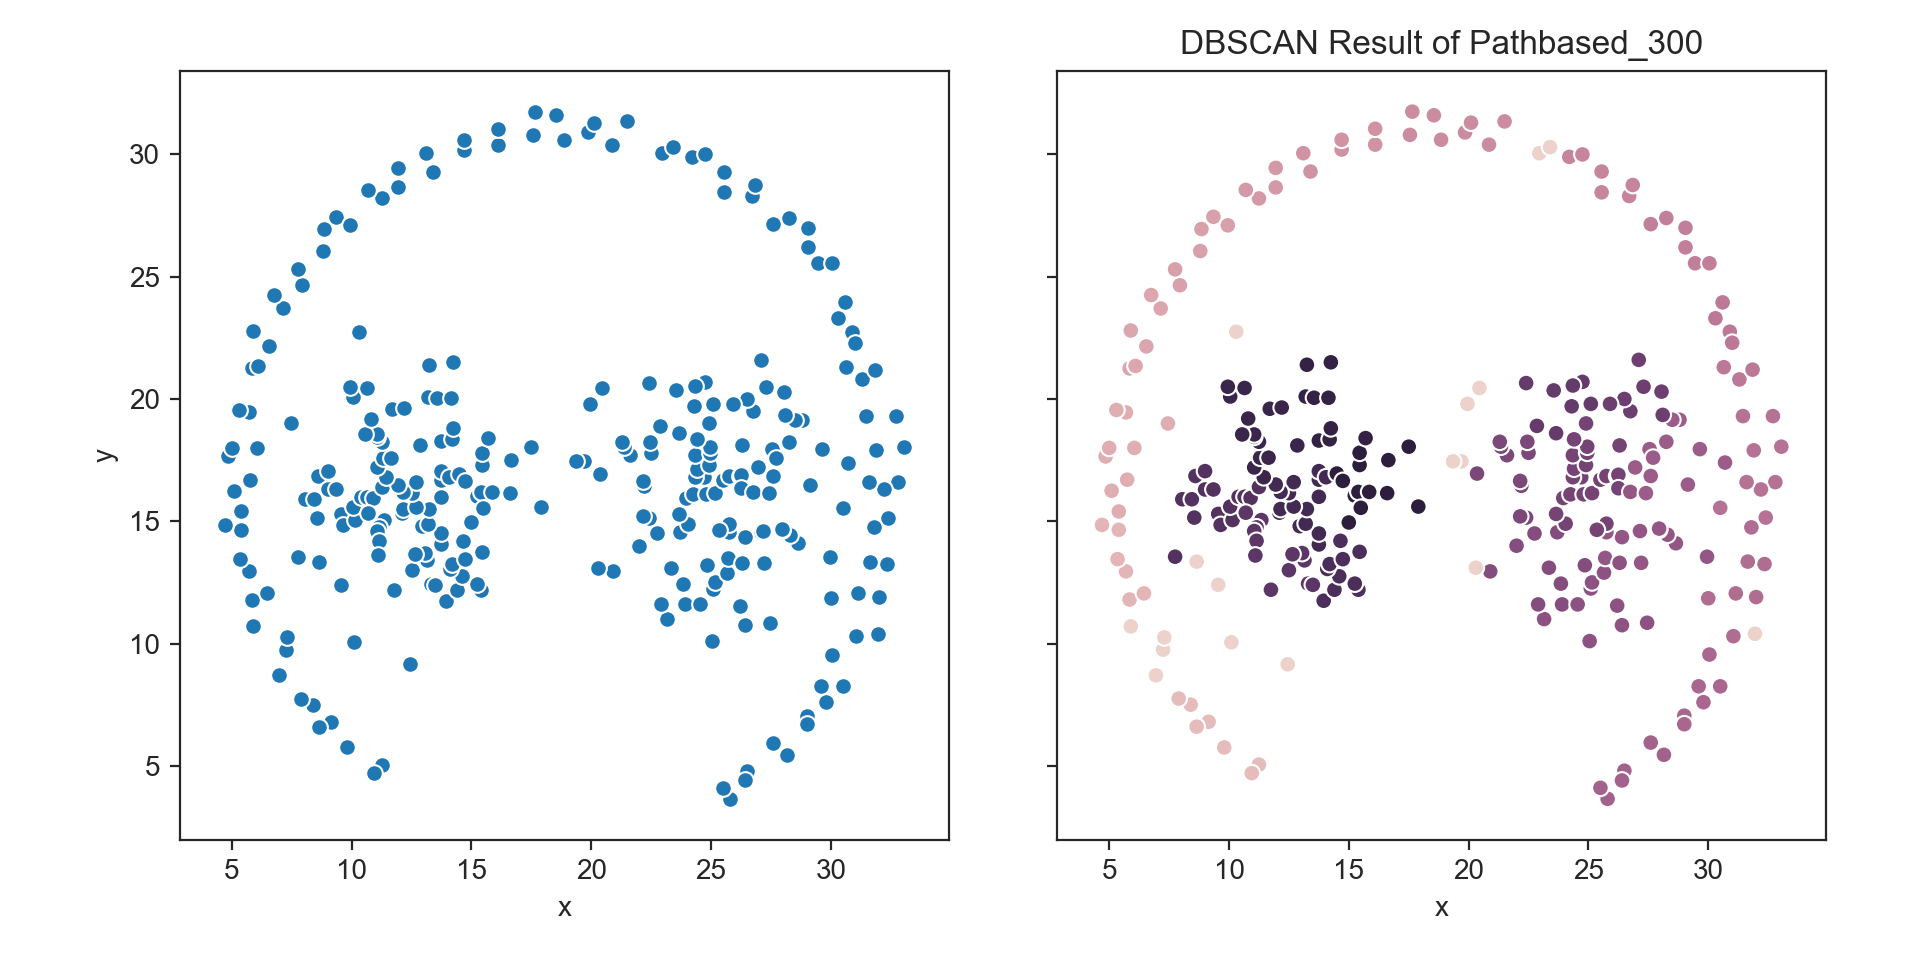

eps: 1.8 min points: 6 silhouette coefficient: 0.38439135919352124


0.38439135919352124

In [110]:
eps = 
min_pts = 
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Pathbased_300')
Evaluation.silhouette_coefficient(mdbscan)

### 5.2.5 spiral_312

In [112]:
test_file = '../../data/shape-sets/spiral.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 3.5
min_pts = 2
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')



SERIAL:
predict time cost: 1181.793ms

SERIAL:
predict time cost: 573.596ms

Partitions: 4

NAIVE:
partition time cost: 17.856ms
merge time cost: 3.668ms
parallel_dbscan time cost: 716.784ms

MATRIX:
partition time cost: 17.371ms
merge time cost: 5.572ms
parallel_dbscan time cost: 231.816ms

FAST-MATRIX:
partition time cost: 19.734ms
merge time cost: 4.554ms
parallel_dbscan time cost: 235.659ms

Partitions: 8

NAIVE:
partition time cost: 24.633ms
merge time cost: 5.245ms
parallel_dbscan time cost: 548.656ms

MATRIX:
partition time cost: 20.211ms
merge time cost: 5.297ms
parallel_dbscan time cost: 207.717ms

FAST-MATRIX:
partition time cost: 21.002ms
merge time cost: 5.279ms
parallel_dbscan time cost: 214.695ms

Partitions: 16

NAIVE:
partition time cost: 32.864ms
merge time cost: 8.017ms
parallel_dbscan time cost: 484.537ms

MATRIX:
partition time cost: 29.716ms
merge time cost: 8.911ms
parallel_dbscan time cost: 218.781ms

FAST-MATRIX:
partition time cost: 32.126ms
merge time cost: 8

predict time cost: 580.972ms


<IPython.core.display.Javascript object>


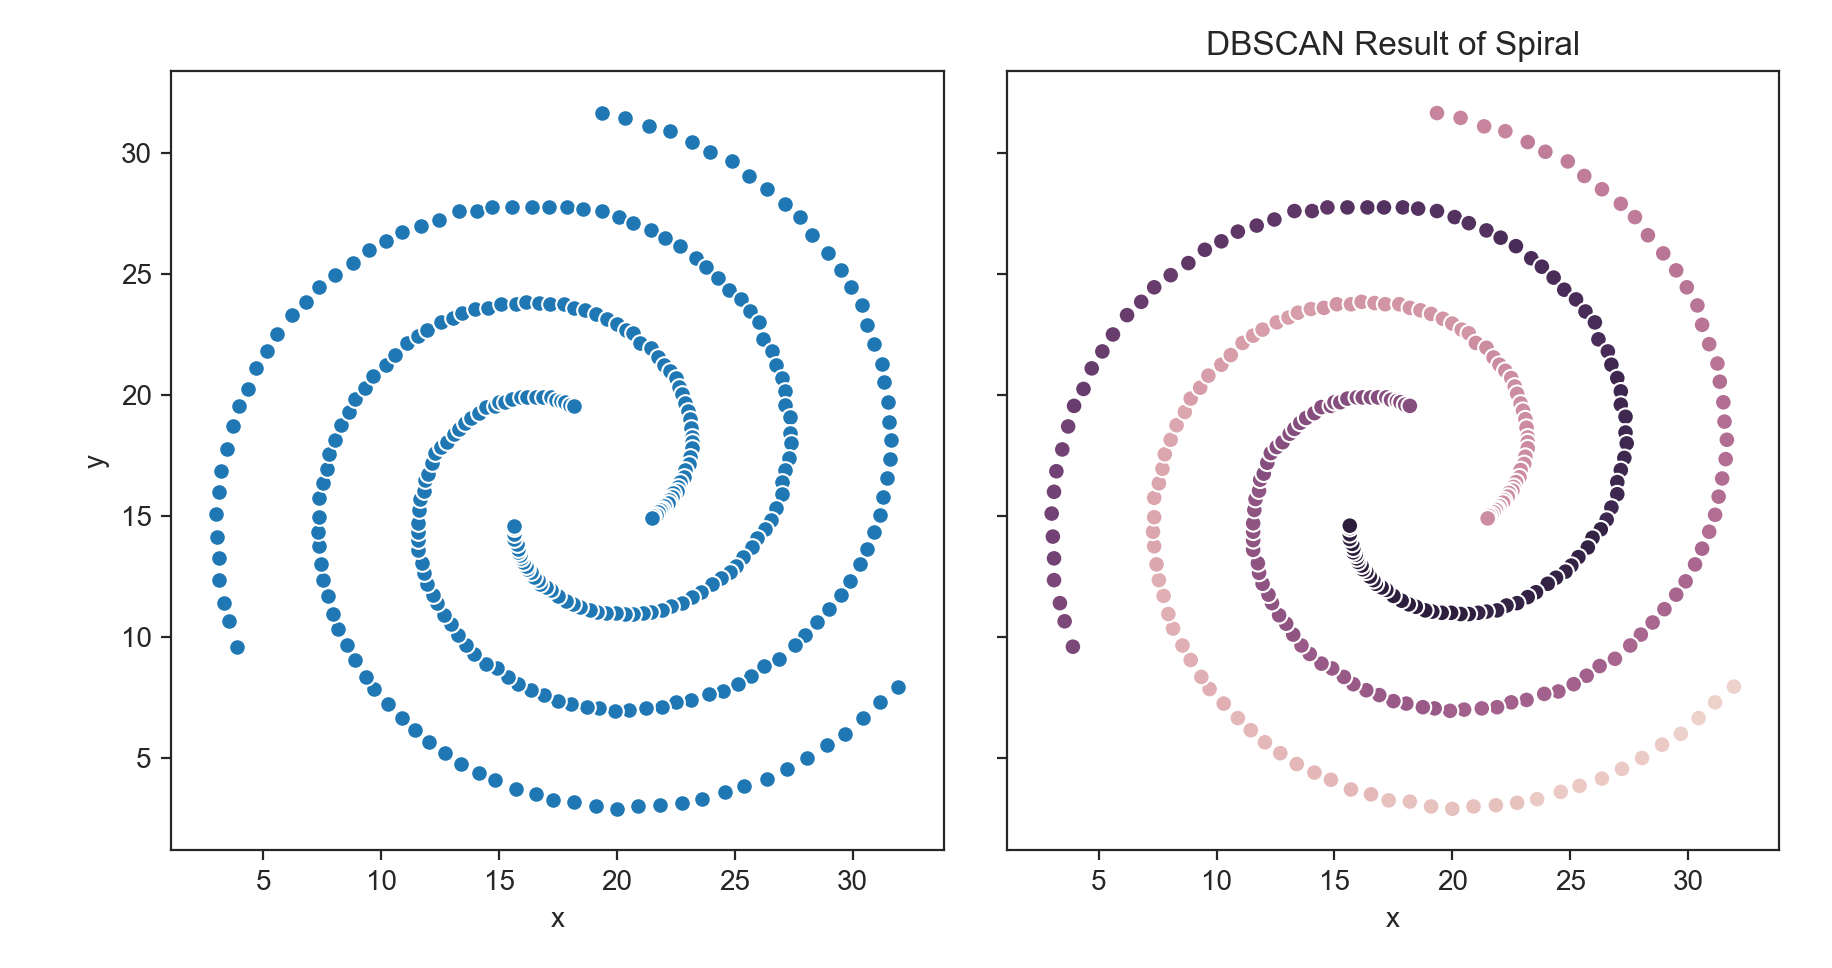

eps: 3.5 min points: 2 silhouette coefficient: 0.4661964889068999


0.4661964889068999

In [94]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Spiral')
Evaluation.silhouette_coefficient(mdbscan)

### 5.2.8 agg_788

In [12]:
test_file = '../../data/shape-sets/aggregation_788.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4]]
# n_partition_set = [[2, 4], [4, 4], [4,8]]
eps = 2.2
min_pts = 23
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

In [13]:
# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')

    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')
    


SERIAL:
predict time cost: 5871.1302280426025ms

SERIAL:
predict time cost: 3347.5961685180664ms
eps: 2.2 min points: 23 silhouette coefficient: 0.3278009890155017

Partitions: 4

NAIVE:
spatial_partition time cost: 25.23207664489746ms
merge time cost: 4.960775375366211ms
parallel_dbscan time cost: 2343.4059619903564ms

MATRIX:
spatial_partition time cost: 28.377771377563477ms
merge time cost: 4.461765289306641ms
parallel_dbscan time cost: 726.8209457397461ms

FAST-MATRIX:
spatial_partition time cost: 25.274276733398438ms
merge time cost: 4.908084869384766ms
parallel_dbscan time cost: 650.454044342041ms

Rtree-rbs:
rtree_partition time cost: 40.7869815826416ms
merge time cost: 4.910945892333984ms
parallel_dbscan time cost: 782.9170227050781ms

Rtree-cbs:
rtree_partition time cost: 39.40701484680176ms
merge time cost: 6.007909774780273ms
parallel_dbscan time cost: 794.2090034484863ms

Partitions: 8

NAIVE:
spatial_partition time cost: 38.340091705322266ms
merge time cost: 6.84618949890

predict time cost: 3833.5838317871094ms
Number of clusters: 16
eps: 3 min points: 34 silhouette coefficient: 0.37706102254990087


<IPython.core.display.Javascript object>


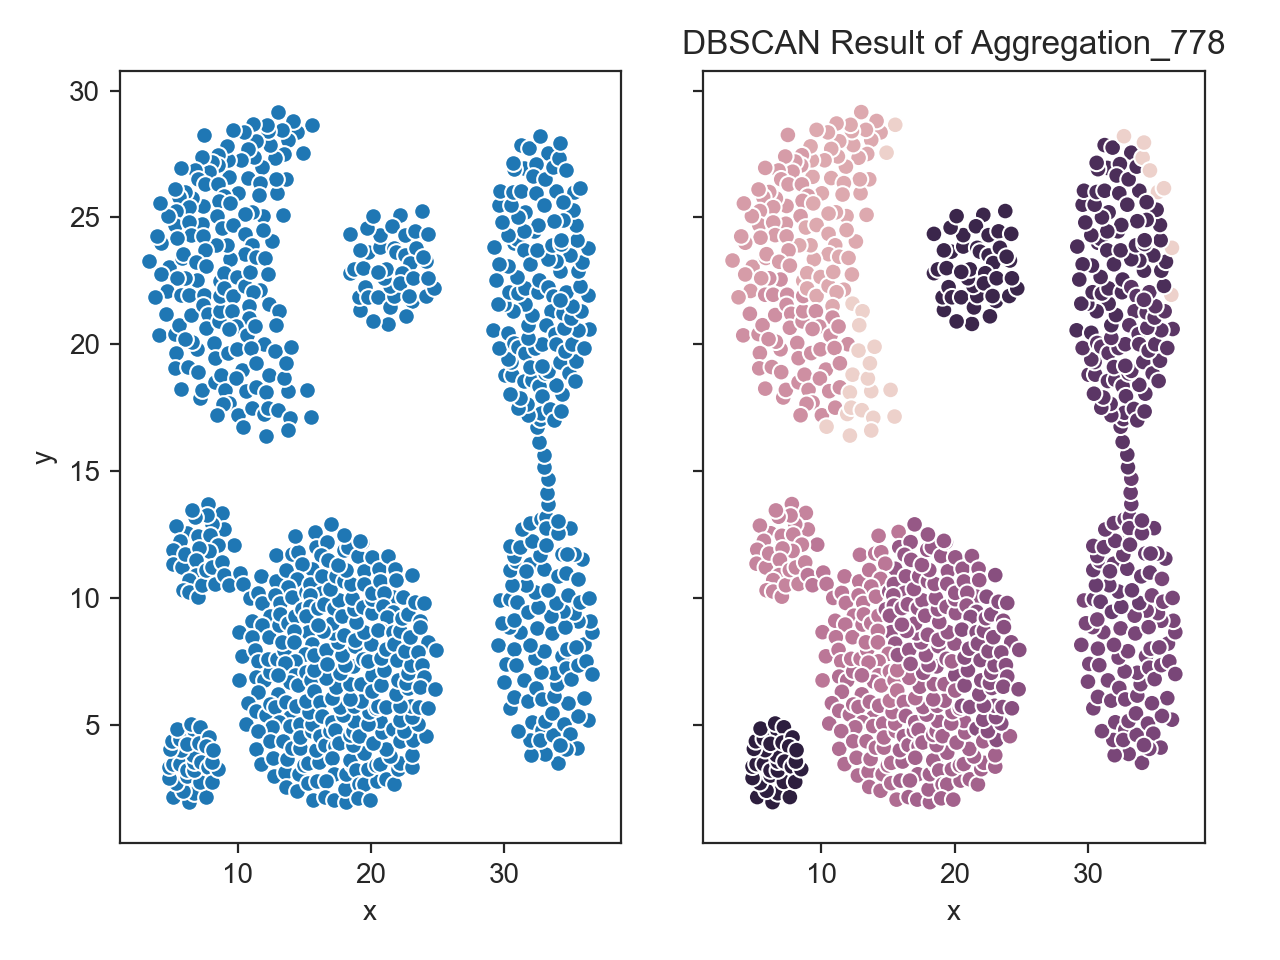

In [148]:
eps = 3
min_pts = 34

mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))
Evaluation.silhouette_coefficient(mdbscan)
plot_result(dataset, result_tags, 'Aggregation_778')

### 5.2.7 d31_3100

In [14]:
test_file = '../../data/shape-sets/d31_3100.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4]]
# n_partition_set = [[2, 4], [4, 4], [4, 8]]
eps = 1.5
min_pts = 70
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

In [15]:
# serial naive
# print('\nSERIAL:')
# mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
# result_tags = mdbscan.predict()

# print('\nSERIAL:')
# mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
# result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')

    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')
    


Partitions: 4

NAIVE:
spatial_partition time cost: 58.4719181060791ms
merge time cost: 21.054983139038086ms
parallel_dbscan time cost: 24410.935163497925ms

MATRIX:
spatial_partition time cost: 54.12101745605469ms
merge time cost: 21.632909774780273ms
parallel_dbscan time cost: 6865.946054458618ms

FAST-MATRIX:
spatial_partition time cost: 55.444955825805664ms
merge time cost: 22.34172821044922ms
parallel_dbscan time cost: 6535.731315612793ms

Rtree-rbs:
rtree_partition time cost: 134.14883613586426ms
merge time cost: 23.312091827392578ms
parallel_dbscan time cost: 7108.587980270386ms

Rtree-cbs:
rtree_partition time cost: 146.94809913635254ms
merge time cost: 26.008129119873047ms
parallel_dbscan time cost: 7068.465232849121ms

Partitions: 8

NAIVE:
spatial_partition time cost: 98.57010841369629ms
merge time cost: 28.924226760864258ms
parallel_dbscan time cost: 18433.552742004395ms

MATRIX:
spatial_partition time cost: 92.60702133178711ms
merge time cost: 28.431177139282227ms
parallel

predict time cost: 58866.63603782654ms


<IPython.core.display.Javascript object>


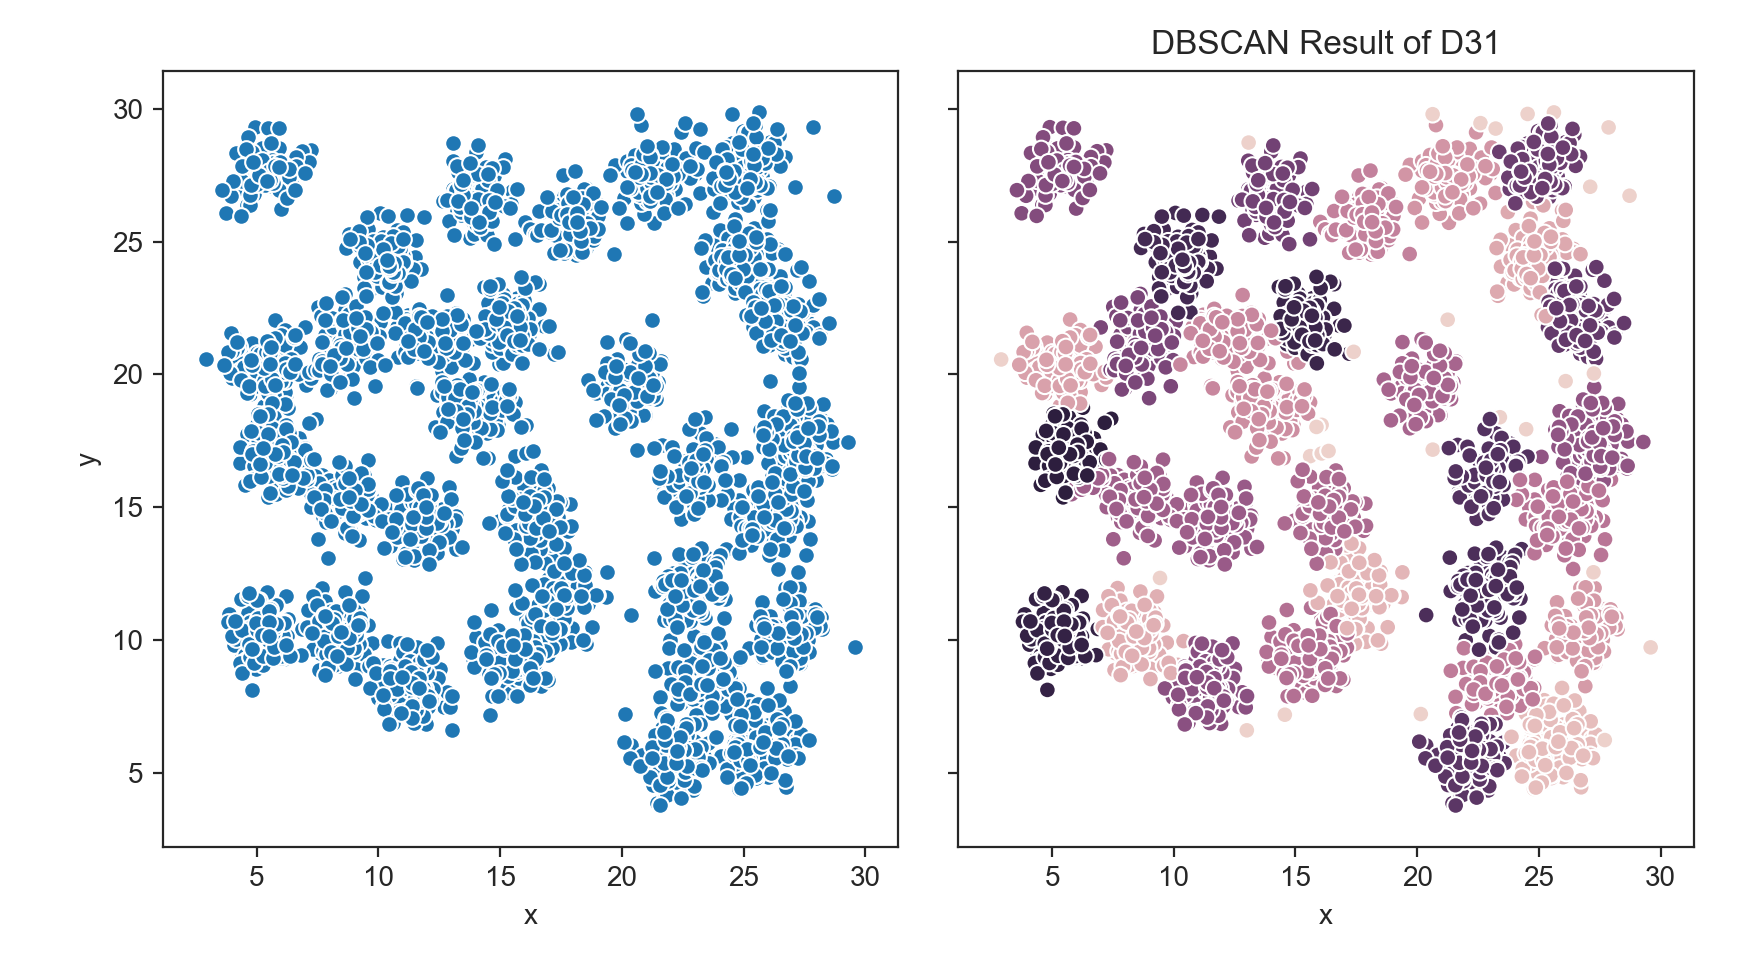

In [150]:
eps = 1.5
min_pts = 70
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))
plot_result(dataset, result_tags, 'D31')